Include all the imports needed 

In [2]:
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing import image
import random 
import math 
from tensorflow.keras.optimizers import Adam

Open and load the pickle feature file and tokenizer files for train and validation

In [3]:
# Load train image features
with open('./train2014_features.pkl', 'rb') as f:
    image_features = pickle.load(f)

# Load train tokienezd captions
with open('./tokenized_train_captions2.pkl', 'rb') as f:
    tokenized_captions = pickle.load(f)

# Load tokenizer 
with open('./tokenizer2.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load validation image features
with open('./val2014_features.pkl', 'rb') as f:
    val_image_features = pickle.load(f)

# Load validation tokienezd captions
with open('./tokenized_val_captions2.pkl', 'rb') as f:
    tokenized_val_captions = pickle.load(f)

# Print traininfo
print('Train Photos (with features):', len(image_features))

# Print val info
print('Val Photos (with features):', len(val_image_features))

count = len(tokenizer.word_index) + 1 # add one for the encoding to work at max index
max_len = max(len(i) for j in tokenized_captions.values() for i in j) # max length of words in a caption 
print(count) # check vocabularu count length 
print(max_len) # check max length of words in a caption count 

Train Photos (with features): 82783
Val Photos (with features): 40504
24784
51


Creating the datagenerator 
Create sequences : Makes the input and outputs for training by converting it into a sequence of integers (tokenizer) and add padding to input and one-hot encoding to output. Returns image features for each word, padding input seuqence of previous words, and the targeted next word 

Data generator: Yielding batches of data one at a time on demand during model training. Goes through all image and caption pairs and calls create sequence 

In [4]:
def create_sequences(tokenizer, max_length, captions, image_feature, vocab_size):
    X1, X2, y = list(), list(), list() 
    
    for seq in captions:  # loop through seq which is a list of integers
        for i in range(1, len(seq)): # loop throguh each integer 
            in_seq, out_seq = seq[:i], seq[i] # create input - output integers

            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] # pad the input 
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # encode the output 

            X1.append(image_feature) # add to list
            X2.append(in_seq) # add to list 
            y.append(out_seq) # add to list 
    return np.array(X1), np.array(X2), np.array(y) # return array 

def data_generator(captions, features, tokenizer, max_length, vocab_size, batch_size):
    while True: 
        X1, X2, y = list(), list(), list() 

        for img_id, cap_list in captions.items(): # loop through each img id and caption pair 
            if img_id in features: # if id exists in image feature 
                image_feature = features[img_id] # get the feature vector 
                input_img, input_seq, output_word = create_sequences(tokenizer, max_length, cap_list, image_feature, vocab_size) # check sequences

                for i in range(len(input_img)): #loop through images features in array
                    X1.append(input_img[i]) # get img feature
                    X2.append(input_seq[i]) # get sequence
                    y.append(output_word[i]) # get predicted word 

                    if len(X1) == batch_size:
                        # yeild when needed 
                        yield (
                            (
                                np.array(X1, dtype='float32'),     # features
                                np.array(X2, dtype='int32')         # sequences
                            ),
                            np.array(y, dtype='float32')            # output words
                        )
                        X1, X2, y = list(), list(), list()


Creating the CNN + LSTM model

Simplest 1 LSTM layer model 

In [5]:
from tensorflow.keras.layers import Add

def CNNLSTM_model(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.5)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 

    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    dense_layer2 = LSTM(256)(dropout2)

    # Combiniding the models 
    decoder1= Add()([dense_layer1,dense_layer2])
    #decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 


2 LSTM layer model 

In [6]:
from tensorflow.keras.layers import Add

def CNNLSTM_model2(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.4)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 

    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)

   # FIRST LSTM layer (returns sequences)
    lstm1 = LSTM(256, return_sequences=True)(dropout2)
    
    # SECOND LSTM layer (returns final state)
    lstm2 = LSTM(256)(lstm1)

    # Combiniding the models 
    decoder1= Add()([dense_layer1,lstm2])
    #decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 


In [7]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Concatenate, Bidirectional

def CNNLSTM_model4(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.5)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 

    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    dense_layer2 = Bidirectional(LSTM(256))(dropout2)  # Bidirectional LSTM for captions

    # Combiniding the models 
    decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 


Training the model 

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Make sure the model directory exists
os.makedirs("models4_1", exist_ok=True)

batch_size = 32
steps_per_epoch = len(image_features) // batch_size 

# Build the model
model_4 = CNNLSTM_model4(count, max_len)
epochs = 10

# Prepare datasets only once
dataset = data_generator(tokenized_captions, image_features, tokenizer, max_len, count, batch_size)

#Save the model after each epoch 
checkpoint_callback = ModelCheckpoint(
    "models4_1/model_epoch_{epoch:02d}.h5",  # Path to save the model (using epoch number in filename)
    monitor="loss",  # Monitor the loss for saving (you can also use validation loss, etc.)
    verbose=1,  # Print out information when saving
    save_best_only=False,  # Set to True to save only the best model based on monitored value
    save_weights_only=False,  # Set to True if you want to save only model weights, not the entire model
    mode="min",  # "min" means saving when the loss decreases; can be "max" for accuracy-based models
)

# Train the model once
model_4.fit(
    dataset,  # Training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint_callback] 
)

# Save the model after training
model_4.save("models4_1/final_model.h5")

print("Training complete.")


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 51, 256)   │  6,344,704 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 2048)      │          0 │ input_layer_18[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 51, 256)   │          0 │ embedding_9[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, 51)        │          0 │ input_layer_19[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 256)       │    524,544 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │  1,050,624 │ dropout_19[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ dense_27[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 24784)     │  6,369,488 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,486,224 (55.26 MB)

 Trainable params: 14,486,224 (55.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 5.4104
Epoch 1: saving model to models4_1/model_epoch_01.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 574s 217ms/step - loss: 5.4102
Epoch 2/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 4.1388
Epoch 2: saving model to models4_1/model_epoch_02.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 465s 180ms/step - loss: 4.1388
Epoch 3/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.0037
Epoch 3: saving model to models4_1/model_epoch_03.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 332s 128ms/step - loss: 4.0037
Epoch 4/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 3.8395
Epoch 4: saving model to models4_1/model_epoch_04.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 340s 131ms/step - loss: 3.8395
Epoch 5/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 3.6997
Epoch 5: saving model to models4_1/model_epoch_05.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 333s 129ms/step - loss: 3.6997
Epoch 6/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 3.7393
Epoch 6: saving model to models4_1/model_epoch_06.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 335s 130ms/step - loss: 3.7393
Epoch 7/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 3.6703
Epoch 7: saving model to models4_1/model_epoch_07.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 341s 132ms/step - loss: 3.6703
Epoch 8/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 3.6521
Epoch 8: saving model to models4_1/model_epoch_08.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 342s 132ms/step - loss: 3.6521
Epoch 9/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 3.5758
Epoch 9: saving model to models4_1/model_epoch_09.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 352s 136ms/step - loss: 3.5758
Epoch 10/10
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 3.5155
Epoch 10: saving model to models4_1/model_epoch_10.h5


2586/2586 ━━━━━━━━━━━━━━━━━━━━ 349s 135ms/step - loss: 3.5155


Training complete.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Make sure the model directory exists
os.makedirs("models8", exist_ok=True)

batch_size = 64
steps_per_epoch = len(image_features) // batch_size 

# Build the model
model = CNNLSTM_model(count, max_len)
epochs = 5

# Prepare datasets only once
dataset = data_generator(tokenized_captions, image_features, tokenizer, max_len, count, batch_size)

#Save the model after each epoch 
checkpoint_callback = ModelCheckpoint(
    "models8/model_epoch_{epoch:02d}.h5",  # Path to save the model (using epoch number in filename)
    monitor="loss",  # Monitor the loss for saving (you can also use validation loss, etc.)
    verbose=1,  # Print out information when saving
    save_best_only=False,  # Set to True to save only the best model based on monitored value
    save_weights_only=False,  # Set to True if you want to save only model weights, not the entire model
    mode="min",  # "min" means saving when the loss decreases; can be "max" for accuracy-based models
)

# Train the model once
model.fit(
    dataset,  # Training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint_callback] 
)

# Save the model after training
model.save("models8/final_model.h5")

print("Training complete.")


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_64      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_32        │ (None, 51, 256)   │  6,344,704 │ input_layer_65[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 2048)      │          0 │ input_layer_64[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 51, 256)   │          0 │ embedding_32[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_46        │ (None, 51)        │          0 │ input_layer_65[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 256)       │    524,544 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ (None, 256)       │    525,312 │ dropout_66[0][0], │
│                     │                   │            │ not_equal_46[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 256)       │          0 │ dense_98[0][0],   │
│                     │                   │            │ lstm_34[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 256)       │     65,792 │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 24784)     │  6,369,488 │ dense_99[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,829,840 (52.76 MB)

 Trainable params: 13,829,840 (52.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - loss: 5.5822
Epoch 1: saving model to models6/model_epoch_01.h5


1293/1293 ━━━━━━━━━━━━━━━━━━━━ 794s 611ms/step - loss: 5.5817
Epoch 2/5
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - loss: 4.1601
Epoch 2: saving model to models6/model_epoch_02.h5


1293/1293 ━━━━━━━━━━━━━━━━━━━━ 788s 610ms/step - loss: 4.1601
Epoch 3/5
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - loss: 4.0007
Epoch 3: saving model to models6/model_epoch_03.h5


1293/1293 ━━━━━━━━━━━━━━━━━━━━ 789s 611ms/step - loss: 4.0007
Epoch 4/5
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - loss: 3.8245
Epoch 4: saving model to models6/model_epoch_04.h5


1293/1293 ━━━━━━━━━━━━━━━━━━━━ 787s 609ms/step - loss: 3.8245
Epoch 5/5
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - loss: 3.6779
Epoch 5: saving model to models6/model_epoch_05.h5


1293/1293 ━━━━━━━━━━━━━━━━━━━━ 831s 642ms/step - loss: 3.6779


Training complete.


Testing the model 

In [8]:
def predict_caption(model, image, tokenizer, max_length):
    start = '<start>'
    image = np.expand_dims(image, axis=0)
    
    for _ in range(max_length):
        # tokenize current caption
        sequence = tokenizer.texts_to_sequences([start])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)

        if word is None:
            break

        start += ' ' + word

        if word == '<end>':
            break

    final_caption = start.split()
    final_caption = final_caption[1:-1]  # remove <start> and <end>
    final_caption = ' '.join(final_caption)
    
    return final_caption


In [9]:
def load_and_show_image(image_id, image_dir):
    filename = image_id + ".jpg"
    img_path = os.path.join(image_dir, filename)
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    return img

In [10]:
import json 
import string
from collections import defaultdict
'''
Default dicionary :
It returns a dictionary-like object that automatically provides a default value 
for missing keys, based on the specified callable, instead of raising a KeyError.
'''

class Parse_MSCOCO:
  def __init__(self, annotation_file, image_directory):
    with open(annotation_file,'r') as file: # reading json file
      coco = json.load(file)
    
    #Dictionaries to store image and annotation data 
    self.image_dictionary = {} # connects image ID to corresponding image information, getting images based on their ID 
    #self.annotations_dictionary = defaultdict(list) # stores image id with list of annotations
    #self.annotations_ID = {} # connects annotation ID to the corresponding annotation information 
    self.caption_dictionary = defaultdict(list) # stores image id with list of captions 

    #Extract values and store them into the dictionaries with their corresponding IDs
    for ann in coco['annotations']:
      #self.annotations_dictionary[ann['image_id']].append(ann)
      #self.annotations_ID[ann['id']] = ann
      self.caption_dictionary[ann['image_id']].append(ann['caption'])

    for img in coco['images']:
      self.image_dictionary[img['id']] = img
  
  #Function to get a list of all image ids 
  def get_imgIds(self):
      return list(self.image_dictionary.keys())

  #Function to get all captions dictionary
  def get_captions(self):
    return self.caption_dictionary

  # Fuction to get list of images with corresponding captions 
  def get_image_with_caption(self, image_ids):
    image_ids = image_ids if isinstance(image_ids,list) else [image_ids]# If image_ids is not a list, single id value
    return [(img_id,self.caption_dictionary[img_id]) for img_id in image_ids] # return tuple list of selected images with their captions 
  
  #Function to formate the captions of specific image(s) with start and end to tonekize later on 

  def get_formatted_captions(self, image_ids):
    image_ids = image_ids if isinstance(image_ids, list) else [image_ids]  # check if single ID or list of tthem

    form_captions = {}

    # Get the corresponding images and their captions using get_image_with_caption
    image_captions = self.get_image_with_caption(image_ids)
    
    for img_id, captions in image_captions: # loop through the dictionary 
        form_captions[img_id] = [] #define empty list image caption pair variable 
        for caption in captions:
            # getting rid of punctuation and convert to lowercase
            caption = caption.translate(str.maketrans('', '', string.punctuation))
            caption = caption.replace("-", " ")
            caption = caption.lower().split()  # Split into words
            caption = ['<start>'] + caption + ['<end>']
            caption = " ".join(caption)
            form_captions[img_id].append(caption)

    return form_captions # return images with corresponding split list captions
    
    # Get img file names 
  def get_img_file_names(self, image_ids):
      image_ids = image_ids if isinstance(image_ids,list) else [image_ids] # If image_ids is not a list, single id value
      return [self.image_dictionary[img_id]['file_name'] for img_id in image_ids]
  
import pickle
import tensorflow as tf
from collections import defaultdict

# Get paths
img_train_path = "./train2014/train2024"
ann_train_path = "./annotations_trainval2014/annotations/captions_train2014.json"

ann_val_path = "./annotations_trainval2014/annotations/captions_val2014.json"
img_val_path = "./val2014"

# Parse data
parser_train = Parse_MSCOCO(ann_train_path, img_train_path)
parser_val = Parse_MSCOCO(ann_val_path, img_val_path)


Testing out weights on CNNLSTM model 1 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_36      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 51, 256)   │  6,344,704 │ input_layer_37[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 2048)      │          0 │ input_layer_36[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 51, 256)   │          0 │ embedding_18[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_18        │ (None, 51)        │          0 │ input_layer_37[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 256)       │    524,544 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 256)       │    525,312 │ dropout_37[0][0], │
│                     │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 256)       │          0 │ dense_46[0][0],   │
│                     │                   │            │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 256)       │     65,792 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 24784)     │  6,369,488 │ dense_47[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,829,840 (52.76 MB)

 Trainable params: 13,829,840 (52.76 MB)

 Non-trainable params: 0 (0.00 B)

COCO_val2014_000000565778
Loading image from: ./val2014/val2014\COCO_val2014_000000565778.jpg
./val2014/val2014\COCO_val2014_000000565778.jpg

Predicted Val Image Caption:
a large train is sitting on a street

Real Val Image Captions Train:
1: A train going back to its coarse filled with people.
2: A blue commuter train traveling towards a train tunnel.
3: Blue train car sitting on a train track near tunnel.
4: A train with people inside is about to go into a tunnel.
5: A blue train on some train tracks about to go under a bridge


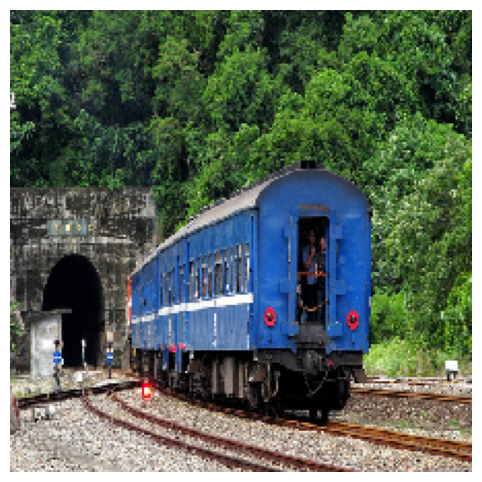

In [ ]:
import matplotlib.pyplot as plt
# Load the saved model
model = CNNLSTM_model(count, max_len)
model.load_weights("models8/final_model.h5")

img_id1 = parser_val.get_imgIds()[300] 

file_name1 = parser_val.get_img_file_names(img_id1)[0]

feature_id1 = file_name1.split('.')[0]  
print(feature_id1)

    # Get the image feature from val_image_features using the filename as the key
image_feature1 = val_image_features.get(feature_id1, None)

    # Generate a caption using the trained model
generated_caption1 = predict_caption(model, image_feature1, tokenizer, max_len)

    # Show the image using the load_and_show_image function
plt.figure(figsize=(8, 6))
    
    # Ensure the filename does not include the '.jpg' extension again
img_path1 = os.path.join('./val2014/val2014', file_name1)  # Make sure only one extension is used
print(f"Loading image from: {img_path1}")
load_and_show_image(feature_id1, './val2014/val2014') 

print("\nPredicted Val Image Caption:")
print(generated_caption1)
    # Retrieve and print the real captions
print("\nReal Val Image Captions Train:")
real_captions1 = parser_val.get_captions()[img_id1]  # Get the real captions for the image ID
for idx, caption in enumerate(real_captions1):
    print(f"{idx + 1}: {caption}")
    
    # Show the image with captions
plt.show()



Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_28      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 51, 256)   │  6,344,704 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 2048)      │          0 │ input_layer_28[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 51, 256)   │          0 │ embedding_14[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 51)        │          0 │ input_layer_29[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 256)       │    524,544 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 256)       │    525,312 │ dropout_29[0][0], │
│                     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dense_42[0][0],   │
│                     │                   │            │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 256)       │     65,792 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 24784)     │  6,369,488 │ dense_43[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,829,840 (52.76 MB)

 Trainable params: 13,829,840 (52.76 MB)

 Non-trainable params: 0 (0.00 B)

COCO_val2014_000000397133
Loading image from: ./val2014/val2014\COCO_val2014_000000397133.jpg
./val2014/val2014\COCO_val2014_000000397133.jpg

Predicted Val Image Caption:
a kitchen with a kitchen with a kitchen and a kitchen

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


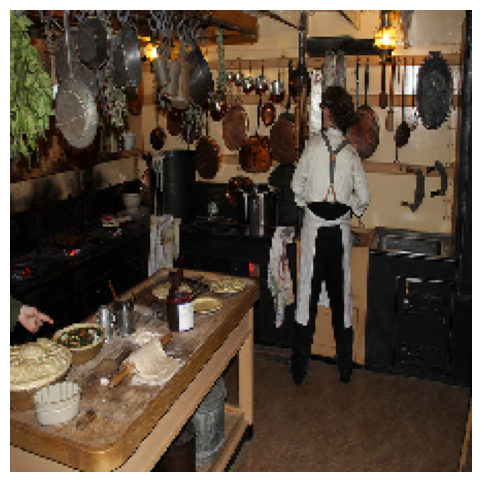

COCO_val2014_000000574769
Loading image from: ./val2014/val2014\COCO_val2014_000000574769.jpg
./val2014/val2014\COCO_val2014_000000574769.jpg

Predicted Val Image Caption:
a kitchen with a kitchen and a kitchen

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


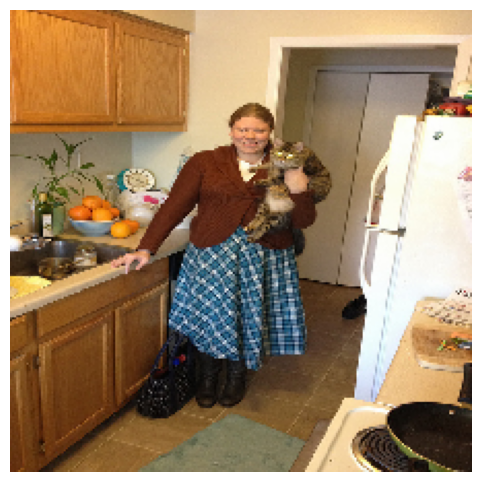

COCO_val2014_000000060623
Loading image from: ./val2014/val2014\COCO_val2014_000000060623.jpg
./val2014/val2014\COCO_val2014_000000060623.jpg

Predicted Val Image Caption:
a woman is sitting on a table with a woman

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


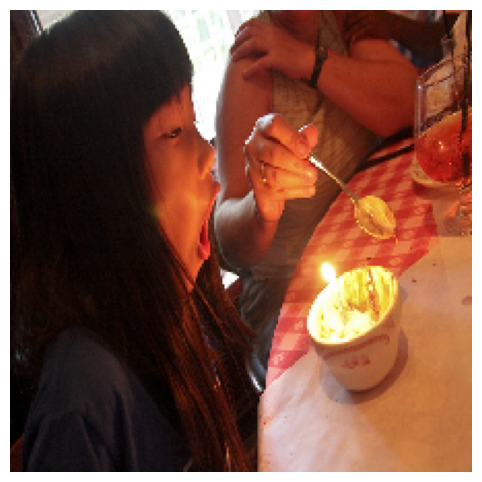

COCO_val2014_000000309022
Loading image from: ./val2014/val2014\COCO_val2014_000000309022.jpg
./val2014/val2014\COCO_val2014_000000309022.jpg

Predicted Val Image Caption:
a kitchen with a kitchen and a kitchen

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


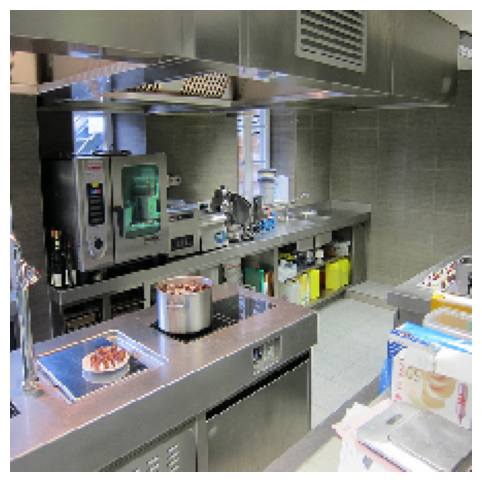

COCO_val2014_000000005802
Loading image from: ./val2014/val2014\COCO_val2014_000000005802.jpg
./val2014/val2014\COCO_val2014_000000005802.jpg

Predicted Val Image Caption:
a woman is sitting on a table with a woman

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


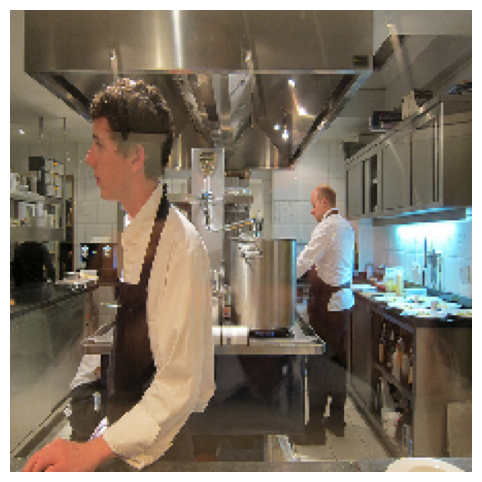

In [25]:
import matplotlib.pyplot as plt
# Load the saved model
model = CNNLSTM_model(count, max_len)
model.load_weights("models8/final_model.h5")

for i in range(5):
    img_id = parser_val.get_imgIds()[i+5]
    file_name1 = parser_val.get_img_file_names(img_id)[0]

    feature_id1 = file_name1.split('.')[0]  
    print(feature_id1)

        # Get the image feature from val_image_features using the filename as the key
    image_feature1 = val_image_features.get(feature_id1, None)

        # Generate a caption using the trained model
    generated_caption1 = predict_caption(model, image_feature1, tokenizer, max_len)

        # Show the image using the load_and_show_image function
    plt.figure(figsize=(8, 6))
        
        # Ensure the filename does not include the '.jpg' extension again
    img_path1 = os.path.join('./val2014/val2014', file_name1)  # Make sure only one extension is used
    print(f"Loading image from: {img_path1}")
    load_and_show_image(feature_id1, './val2014/val2014') 

    print("\nPredicted Val Image Caption:")
    print(generated_caption1)
        # Retrieve and print the real captions
    print("\nReal Val Image Captions Train:")
    real_captions1 = parser_val.get_captions()[img_id1]  # Get the real captions for the image ID
    for idx, caption in enumerate(real_captions1):
        print(f"{idx + 1}: {caption}")
        
        # Show the image with captions
    plt.show()



MODEL 4 Examples

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 51, 256)   │  6,344,704 │ input_layer_27[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 2048)      │          0 │ input_layer_26[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 51, 256)   │          0 │ embedding_13[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (None, 51)        │          0 │ input_layer_27[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 256)       │    524,544 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512)       │  1,050,624 │ dropout_27[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ dense_39[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 256)       │    196,864 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 24784)     │  6,369,488 │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,486,224 (55.26 MB)

 Trainable params: 14,486,224 (55.26 MB)

 Non-trainable params: 0 (0.00 B)

COCO_val2014_000000397133
Loading image from: ./val2014/val2014\COCO_val2014_000000397133.jpg
./val2014/val2014\COCO_val2014_000000397133.jpg

Predicted Val Image Caption:
a bathroom with a sink and a sink

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


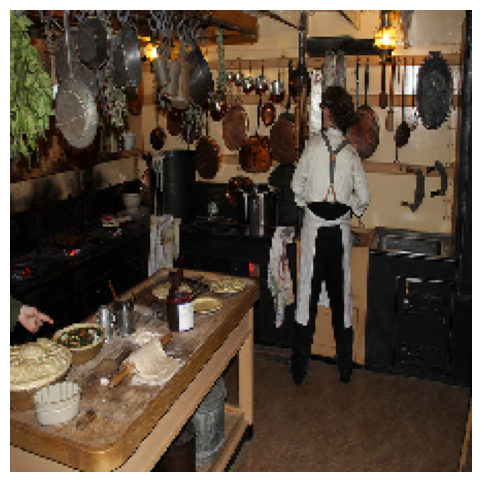

COCO_val2014_000000574769
Loading image from: ./val2014/val2014\COCO_val2014_000000574769.jpg
./val2014/val2014\COCO_val2014_000000574769.jpg

Predicted Val Image Caption:
a man is standing in a kitchen with a white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


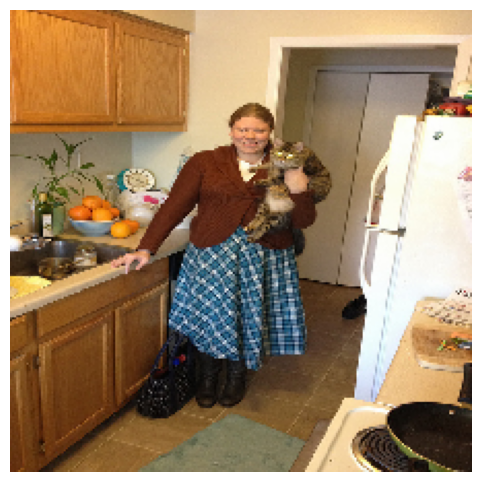

COCO_val2014_000000060623
Loading image from: ./val2014/val2014\COCO_val2014_000000060623.jpg
./val2014/val2014\COCO_val2014_000000060623.jpg

Predicted Val Image Caption:
a man is standing in a kitchen with a white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


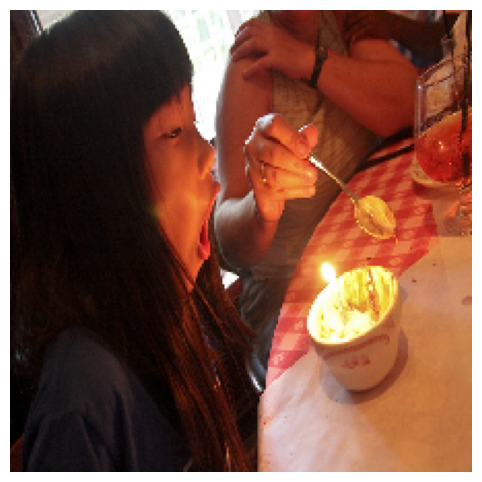

COCO_val2014_000000309022
Loading image from: ./val2014/val2014\COCO_val2014_000000309022.jpg
./val2014/val2014\COCO_val2014_000000309022.jpg

Predicted Val Image Caption:
a bathroom with a toilet and a toilet

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


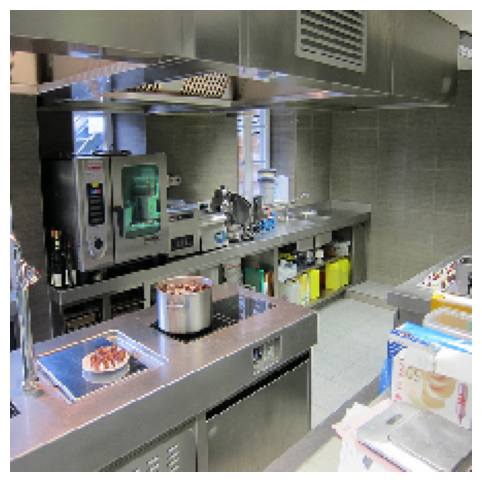

COCO_val2014_000000005802
Loading image from: ./val2014/val2014\COCO_val2014_000000005802.jpg
./val2014/val2014\COCO_val2014_000000005802.jpg

Predicted Val Image Caption:
a man is standing in a kitchen with a white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


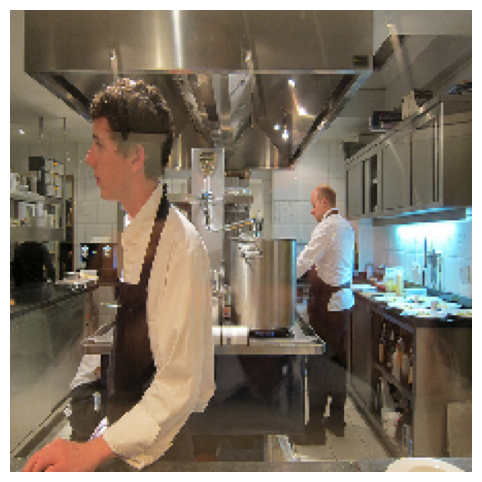

COCO_val2014_000000222564
Loading image from: ./val2014/val2014\COCO_val2014_000000222564.jpg
./val2014/val2014\COCO_val2014_000000222564.jpg

Predicted Val Image Caption:
a man is standing in a kitchen with a white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


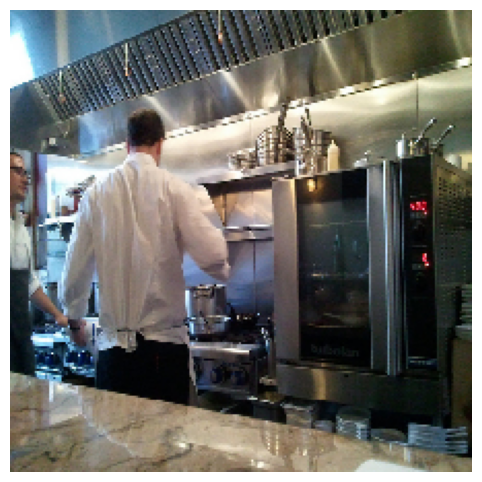

COCO_val2014_000000118113
Loading image from: ./val2014/val2014\COCO_val2014_000000118113.jpg
./val2014/val2014\COCO_val2014_000000118113.jpg

Predicted Val Image Caption:
a bathroom with a sink and a sink

Real Val Image Captions Train:
1: A bedroom with a blue bed surrounded by metal stools.
2: A living room with funky blue furniture in it
3: a blue table with some stuff on top of it
4: A room with all blue and white furnitures.
5: There are many different types of furniture in the room.


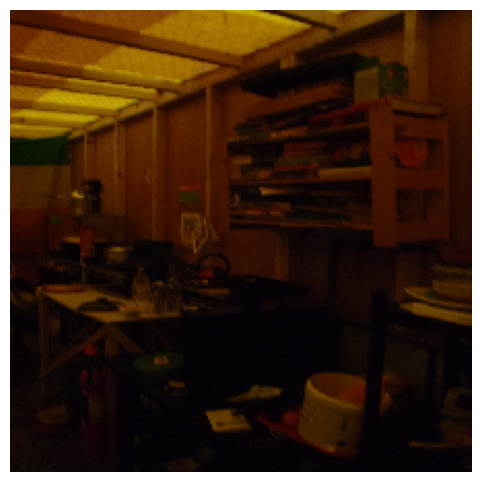

In [24]:
import matplotlib.pyplot as plt
# Load the saved model
model = CNNLSTM_model4(count, max_len)
model.load_weights("models4_1/final_model.h5")

img_id1 = parser_val.get_imgIds()[8000] 

for i in range(7):
    img_id = parser_val.get_imgIds()[i+5]
    file_name1 = parser_val.get_img_file_names(img_id)[0]

    feature_id1 = file_name1.split('.')[0]  
    print(feature_id1)

        # Get the image feature from val_image_features using the filename as the key
    image_feature1 = val_image_features.get(feature_id1, None)

        # Generate a caption using the trained model
    generated_caption1 = predict_caption(model, image_feature1, tokenizer, max_len)

        # Show the image using the load_and_show_image function
    plt.figure(figsize=(8, 6))
        
        # Ensure the filename does not include the '.jpg' extension again
    img_path1 = os.path.join('./val2014/val2014', file_name1)  # Make sure only one extension is used
    print(f"Loading image from: {img_path1}")
    load_and_show_image(feature_id1, './val2014/val2014') 

    print("\nPredicted Val Image Caption:")
    print(generated_caption1)
        # Retrieve and print the real captions
    print("\nReal Val Image Captions Train:")
    real_captions1 = parser_val.get_captions()[img_id1]  # Get the real captions for the image ID
    for idx, caption in enumerate(real_captions1):
        print(f"{idx + 1}: {caption}")
        
        # Show the image with captions
    plt.show()

